### Import libraries

In [ ]:
import pandas as pd
import json
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.utils import to_categorical
import os
from keras.models import Model
import gzip
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Info for the dataset

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/MyDrive/qa_Electronics (1).json.gz')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314263 entries, 0 to 314262
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   questionType  314263 non-null  object 
 1   asin          314263 non-null  object 
 2   answerTime    314263 non-null  object 
 3   unixTime      304873 non-null  float64
 4   question      314263 non-null  object 
 5   answerType    165598 non-null  object 
 6   answer        314263 non-null  object 
dtypes: float64(1), object(6)
memory usage: 19.2+ MB


In [ ]:
#check the null values
df.isnull().sum()

questionType         0
asin                 0
answerTime           0
unixTime          9390
question             0
answerType      148665
answer               0
dtype: int64

In [ ]:
print(df.duplicated().sum())
print(df.drop_duplicates(inplace=True,keep='last'))

969
None


In [ ]:
# drop unwanted columns
df.drop(columns=['questionType','asin','answerTime','unixTime','answerType'],inplace=True)

In [ ]:
# print number of questions the have length less then or equal 10
count_question= [i for i in df['question'] if  len(i.split()) <= 10]
print("Total Questions: ",len(count_question))
count_answer= [i for i in df['answer'] if  len(i.split()) <= 10]
print("Total Anwers: ",len(count_answer))

Total Questions:  139780
Total Anwers:  88709


In [ ]:
df

,question,answer
0,Is this cover the one that fits the old nook c...,Yes this fits both the nook color and the same...
1,Does it fit Nook GlowLight?,No. The nook color or color tablet
4,will this fit the Samsung Galaxy Tab 4 Nook 10.1,"No, the tab is smaller than the 'color'"
5,does it have a flip stand?,"No, there is not a flip stand. It has a pocket..."
6,does this have a flip stand,"Hi, no it doesn't"
...,...,...
314254,"will this device work in grand canyon, where n...",It works on the 2G network. No Cell no workie....
314258,Is the space from bottom of desktop to tray ad...,No
314259,can the mouse extension be mounted on the LEFT...,"yes, you can put it on which ever side you want"
314260,does it come with all the hardware,"It's been a while since I bought this, but I'm..."


In [ ]:
def remove_qn_ans(col_type):
    data_id = []
    for i, val in enumerate(df[col_type]):
        if len(val.split()) >= 10 :
            data_id.append(i)
            
    print('Count of ',col_type,' will be removed: ',len(data_id))
    return data_id
def remove_qn_ans_alternate(col_type):
    data_id = []
    checker = 0
    for i, val in enumerate(df[col_type]):
        if len(val) <= 3 and checker < 2:
            data_id.append(i)
            checker += 1
        elif val.find("http:")!= -1:
            data_id.append(i)
        else:
            checker = 0
            
    print('Count of ',col_type,' will be removed: ',len(data_id))
    return data_id
df = df.drop(df.index[remove_qn_ans('question')])
df.reset_index(drop=True, inplace=True)
df = df.drop(df.index[remove_qn_ans('answer')])
df.reset_index(drop=True, inplace=True)

# df = df.drop(df.index[remove_qn_ans_alternate('answer')])
# df.reset_index(drop=True, inplace=True)

Count of  question  will be removed:  190030
Count of  answer  will be removed:  80097


### Preprocessing part

In [ ]:
def clean_text(text):
    text = re.sub(r"\s+"," ",str(text)) # to remove white space
    text = re.sub(r"<[^>]+>"," ",str(text)) # remove html tags
    text = re.sub(r"[^A-Za-zÀ-ž-Z0-9'.,]"," ",str(text)) # not clean A-Za-zÀ-ž-Z0-9
    word_tokens = text.split()
    text_clean = " ".join(word_tokens)
    return text_clean


In [ ]:
df['final_answer']=df['answer'].apply(lambda x:clean_text(x))
df['final_question']=df['question'].apply(lambda x:clean_text(x))

In [ ]:
df

,question,answer,final_answer,final_question
0,Does it fit Nook GlowLight?,No. The nook color or color tablet,No. The nook color or color tablet,Does it fit Nook GlowLight
1,does this have a flip stand,"Hi, no it doesn't","Hi, no it doesn't",does this have a flip stand
2,how far out does the arm extend?,18 inches on our TV.,18 inches on our TV.,how far out does the arm extend
3,Does it work with MacBook Air mid2012?,yep,yep,Does it work with MacBook Air mid2012
4,Does this work with mac mini?,Yes,Yes,Does this work with mac mini
...,...,...,...,...
43162,can you use this laptop on dsl + satellite,"Yep, it doesn't have a cd rom though.","Yep, it doesn't have a cd rom though.",can you use this laptop on dsl satellite
43163,Does it have a CD drive ?,No. It has no CD/DVD Drive,No. It has no CD DVD Drive,Does it have a CD drive
43164,Does this unit have a Ethernet connectioon?,Yes,Yes,Does this unit have a Ethernet connectioon
43165,Does it have a camera?,yes,yes,Does it have a camera


In [ ]:
questions =  df.final_question.values.tolist()
questions = questions[0:500]
print(len(questions))
answers = df.final_answer.values.tolist()
answers = answers[0:500]
print(len(answers))

500
500


In [ ]:
questions

['does it fit nook glowlight',
 'does this have a flip stand',
 'does it work with macbook air mid2012',
 'does this work with mac mini',
 'does this item come with a charger',
 'does this nook play games',
 'does this model have an sd card slot',
 'can i download the kindle app for this',
 'can you download netflix',
 'is it user friendly',
 'can i play facebook games on it',
 'can i download the kindle app',
 'is this compatible with mac os 10.4.11',
 'can it play games for computer',
 'does it work with an imac',
 'will these batteries work in the bushnell range finder',
 'does the charger work for aa aaa batteries as well',
 'do you carry this product in white',
 'will this work in italy',
 'does it work for a gopro hero',
 'will this work for the gopro 4 silver',
 'does the adapter come with sd micro',
 'can you download save apps in this card',
 'does it work in other samsung phones',
 'will this work in a samsung s4 mini',
 'will this work in a samsung ace 3 s7275',
 'is possibl

In [ ]:
# add a start word at the beginning of the sentence and an end word at the end.
answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str :
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )
answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append('<START>'+answers_with_tags[i]+ ' <END>' )

In [ ]:
answers

['<START>No. The nook color or color tablet <END>',
 "<START>Hi, no it doesn't <END>",
 '<START>18 inches on our TV. <END>',
 '<START>yep <END>',
 '<START>Yes <END>',
 '<START>Ours did <END>',
 '<START>yes <END>',
 '<START>No, Nook Glowlight does not have a camera. <END>',
 '<START>No it does not .... Sorry <END>',
 '<START>Yes it has an sd card slot <END>',
 '<START>In the shades ok direct sun not so good <END>',
 '<START>Yes you can. I have it installed <END>',
 '<START>Yes, you can also use the Amazon Kindle app. <END>',
 "<START>It not slow. It is your internet that's slow. <END>",
 '<START>Very much. Both my 9 4yr old csn use it <END>',
 '<START>No it is only a reader <END>',
 '<START>No <END>',
 '<START>No <END>',
 '<START>I got mine from Overstock.com. Standard size table cover. <END>',
 '<START>i dont know <END>',
 '<START>Yes. <END>',
 '<START>Yes, it works on ANY Mac <END>',
 "<START>Why wouldn't it <END>",
 '<START>no <END>',
 '<START>http www.amazon.com Microphone-Recorder-

In [ ]:
tokenizer =Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 1129


In [ ]:
import pickle
with open('answers_English.pkl', 'wb') as file:
    pickle.dump(answers, file)
with open('questions_English.pkl', 'wb') as file:
    pickle.dump(questions, file)

In [ ]:
#question
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [ len(x) for x in tokenized_questions ] )
padded_questions = pad_sequences( tokenized_questions , maxlen=maxlen_questions , padding='post' )
encoder_input_data = np.array( padded_questions )
print( encoder_input_data.shape , maxlen_questions )
#answer
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )


(500, 13) 13
(500, 31) 31


In [ ]:
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )

In [ ]:
padded_answers

array([[  14,    5, 1113, ...,    0,    0,    0],
       [  14,    5, 1027, ...,    0,    0,    0],
       [ 143,   14,    3, ...,    0,    0,    0],
       ...,
       [  65,   13,   32, ...,    0,    0,    0],
       [   3,    9,   19, ...,    0,    0,    0],
       [  14,    1,    0, ...,    0,    0,    0]], dtype=int32)

In [ ]:
onehot_answers = to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape)

(500, 31, 1129)


### Model

In [ ]:
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=( 13 , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 400 , return_state=True ,dropout=0.3)( encoder_embedding )
encoder_states = [ state_h , state_c ]
# Decoder
decoder_inputs = tf.keras.layers.Input(shape=( 31 ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 400 , return_state=True , return_sequences=True,dropout=0.3 )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy',metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 13, 200)      225800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 31, 200)      225800      ['input_2[0][0]']                
                                                                                              

In [ ]:
h=model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=32, epochs=50, use_multiprocessing= True) 
model.save( 'model_lstm.h5' )

Epoch 1/50
 7/16 [============>.................] - ETA: 4s - loss: 0.8728 - acc: 0.3375

In [ ]:
from keras.models import load_model
model=load_model('model_lstm3.h5')

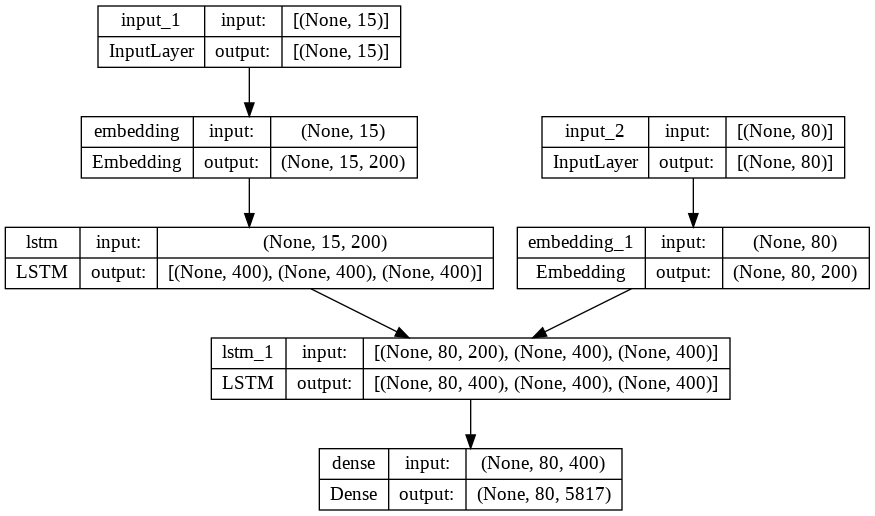

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [ ]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 400 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 400 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model
def str_to_tokens( sentence : str ):
    words = clean_text(sentence).split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [ ]:
enc_model , dec_model = make_inference_models()
enc_model=enc_model.save('encoder_model_english3.h5')
dec_model=dec_model.save('decoder_model_english3.h5')


In [ ]:
def decode_response(text):
        states_values = enc_model.predict(text )
        empty_target_seq = np.zeros( ( 1 , 1 ) )
        empty_target_seq[0, 0] = tokenizer.word_index['start']
        stop_condition = False
        decoded_translation = ''
        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
            sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
            sampled_word = None
            for word , index in tokenizer.word_index.items() :
                if sampled_word_index == index :
                    decoded_translation += ' {}'.format( word )
                    sampled_word = word
#             else:
#                 decoded_translation = "I am sorry! I don't understand you"
        
            if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
               stop_condition = True
            
            empty_target_seq = np.zeros( ( 1 , 1 ) )  
            empty_target_seq[ 0 , 0 ] = sampled_word_index
            states_values = [ h , c ] 
        return "Bot:" +decoded_translation.replace(' end', '')

In [ ]:
def generate_response(text):
    input_matrix = str_to_tokens(text)
    chatbot_response = decode_response(input_matrix)
  #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response


In [ ]:
generate_response('can you use this laptop on satellite')

'Bot: yes you can'